In [1]:
from pyAPES.utils.iotools import read_forcing
from pyAPES.pyAPES_MLM import driver

from pyAPES.parameters.SmearII_parameters import gpara, cpara, spara

In [2]:
forcing = read_forcing(
    forcing_file=gpara['forc_filename'],
    start_time=gpara['start_time'],
    end_time=gpara['end_time'],
    dt=gpara['dt'])

params = {
    'general': gpara,
    'canopy': cpara,
    'soil': spara,
    'forcing': forcing}

resultfile, _ = driver(parameters=params,
                       create_ncf=True,
                       result_file= 'FiHy2018.nc')

INFO pyAPES.pyAPES_MLM driver pyAPES_MLM simulation started. Number of simulations: 1
INFO pyAPES.soil.water __init__ Water balance in soil not solved.
INFO pyAPES.soil.heat __init__ Soil heat balance not solved. Using prescribed (time-dependent) inputs
INFO pyAPES.canopy.mlm_canopy __init__ Eflow: True, WMA: False, Ebal: True
INFO pyAPES.microclimate.radiation __init__ Shortwave radiation model: ZHAOQUALLS
INFO pyAPES.microclimate.radiation __init__ Longwave radiation model: ZHAOQUALLS
c:\dev\Git_repos\pyAPES_main\pyAPES\bottomlayer\organiclayer.py:1177: RuntimeWarning: invalid value encountered in scalar power
  Psi = -1e-2 / alfa*(s**(1.0 / m) - 1.0)**(1.0 / n)  # m
INFO pyAPES.canopy.forestfloor __init__ Forestfloor has 1 bottomlayer types


Soil moisture from forcing file
Soil temperature from forcing file


INFO pyAPES.pyAPES_MLM driver Running simulation number (start time 2025-10-07 13:55): 0
INFO pyAPES.pyAPES_MLM run Running simulation 0
c:\dev\Git_repos\pyAPES_main\pyAPES\planttype\planttype.py:614: RuntimeWarning: invalid value encountered in scalar divide
  pt_stats[variable] = (np.sum(sl[variable]*f1*np.maximum(0.0, sl['net_co2']) +
c:\dev\Git_repos\pyAPES_main\pyAPES\bottomlayer\organiclayer.py:1114: RuntimeWarning: invalid value encountered in power
  relative_diffusivity = (np.power(Ta / 293.16, 1.75) * np.power(afp, 10.0/3.0) / porosity**2)


0%.. 10%.. 20%.. 30%.. 40%.. 50%.. 60%.. 70%.. 80%.. 90%.. 

INFO pyAPES.pyAPES_MLM run Finished simulation 0, running time 1035.64 seconds
INFO pyAPES.pyAPES_MLM driver Running time 1035.64 seconds


100%


INFO pyAPES.pyAPES_MLM driver Ready! Results are in: results/FiHy2018.nc


In [3]:
from pyAPES.utils.iotools import read_results, read_data
import matplotlib.pyplot as plt
from pyAPES_utilities.plotting import plot_fluxes
import numpy as np
import pandas as pd

MOLAR_MASS_H2O = 18.015 
MOLAR_MASS_CO2 = 44.01

%matplotlib widget

# read simulation results to xarray
results = read_results(resultfile)

# read EC fluxdata
flxdata = read_data(r'data\FIHy_flx_2018.dat', sep=';',
                    start_time=results.date[0].values, end_time=results.date[-1].values)


c:\dev\Git_repos\pyAPES_main\pyAPES_utilities\plotting.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plot_xy(Data[Data_var[i]][ix], Data[res_var[i]][ix], color=pal[i], axislabels=labels,l1=l1)
c:\dev\Git_repos\pyAPES_main\pyAPES_utilities\plotting.py:89: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plot_diurnal(Data[Data_var[i]][ix], color='k', legend=False)
c:\dev\Git_repos\pyAPES_main\pyAPES_utilities\timeseries_tools.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To a

********** computing diurnal cycles *********
Daily sum :150.12199999999999 mm/d
********** computing diurnal cycles *********
Daily sum :155.019857100413 mm/d
********** computing diurnal cycles *********
Daily sum :27.8505 mm/d
********** computing diurnal cycles *********
Daily sum :28.267996557056904 mm/d


c:\dev\Git_repos\pyAPES_main\pyAPES_utilities\plotting.py:95: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout(rect=(0, 0, 0.88, 1), pad=0.5)


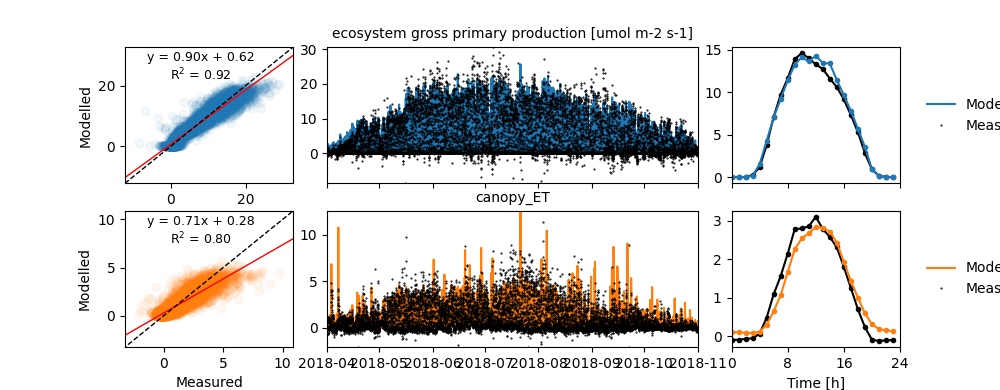

In [4]:
results['canopy_ET'] = (results['canopy_transpiration'] * 1000.0 +
                        results['canopy_evaporation'] +
                        results['ffloor_evaporation']) / 18.015e-3 * 1e3

plot_fluxes(results, flxdata, norain=True,
            res_var=['canopy_GPP', 'canopy_ET'],
            Data_var=['GPP', 'ET'], fmonth=4, lmonth=10)

In [ ]:
cuvdata = pd.read_csv(r'data/FiHy_cuv_FFlux2018.425', delim_whitespace=True, header=0)  # from https://zenodo.org/records/10360968

cuvdata.replace(-999, np.nan, inplace=True)

cuvdata.rename(columns={
    "yyyy": "year", "mm": "month", "dd": "day", "HH": "hour", "MM": "minute",
    }, inplace=True)
cuvdata["datetime"] = pd.to_datetime(cuvdata[["year", "month", "day", "hour", "minute"]])
cuvdata.set_index("datetime", inplace=True)

# F_H2O unreliable at high RH
cuvdata.loc[cuvdata['RHcuv'] > 85, 'F_H2O'] = np.nan

# unit coversion (from all-sided LAI to one-sided LAI)
cuvdata['F_CO2'] = 2 * cuvdata['F_CO2'] / MOLAR_MASS_CO2  # (umol m-2 s-1)
cuvdata['F_H2O'] = 2 * cuvdata['F_H2O'] / MOLAR_MASS_H2O  # (mmol m-2 s-1)

cuvdata_halfhourly = cuvdata.resample("30min").mean()

C:\Users\03110850\AppData\Local\Temp\ipykernel_23556\596772435.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  cuvdata = pd.read_csv(r'data/FiHy_cuv_FFlux2018.425', delim_whitespace=True, header=0)  # from https://zenodo.org/records/10360968


c:\dev\Git_repos\pyAPES_main\pyAPES_utilities\plotting.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plot_xy(Data[Data_var[i]][ix], Data[res_var[i]][ix], color=pal[i], axislabels=labels,l1=l1)
c:\dev\Git_repos\pyAPES_main\pyAPES_utilities\plotting.py:89: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plot_diurnal(Data[Data_var[i]][ix], color='k', legend=False)
c:\dev\Git_repos\pyAPES_main\pyAPES_utilities\timeseries_tools.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To a

********** computing diurnal cycles *********
Daily sum :81.14851548890404 mm/d
********** computing diurnal cycles *********
Daily sum :85.87874089181423 mm/d
********** computing diurnal cycles *********
Daily sum :11.645203071514478 mm/d
********** computing diurnal cycles *********
Daily sum :12.208070561755449 mm/d


c:\dev\Git_repos\pyAPES_main\pyAPES_utilities\plotting.py:95: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout(rect=(0, 0, 0.88, 1), pad=0.5)


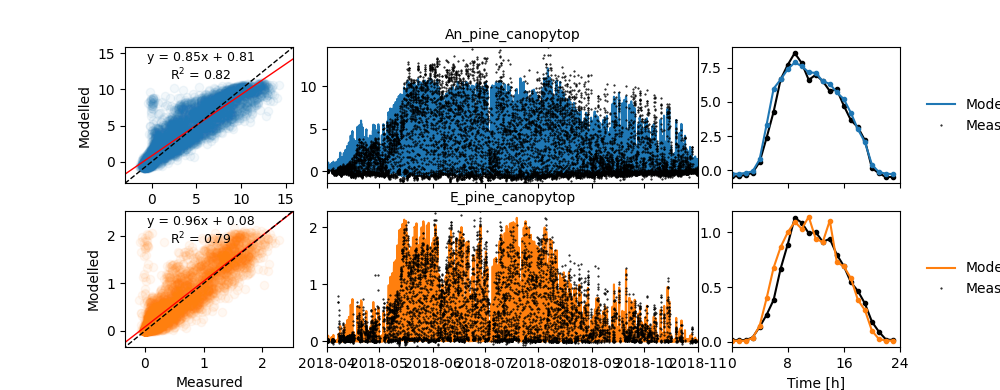

In [8]:
i=80  # position in canopy (layer 1...100)
f = results['canopy_sunlit_fraction'][:,0,i] / results['canopy_sunlit_fraction'][:,0,i].max()  # shoot is fully sunlit at midday
results['An_pine_canopytop'] = (results['pt_net_co2_sunlit'][:,:,1,i] * f  
                                + results['pt_net_co2_shaded'][:,:,1,i] * (1 - f)) 
results['E_pine_canopytop'] = 1e3*(results['pt_transpiration_sunlit'][:,:,1,i] * f  
                                + results['pt_transpiration_shaded'][:,:,1,i] * (1 - f))  

plot_fluxes(results, cuvdata_halfhourly, norain=True,
            res_var=['An_pine_canopytop', 'E_pine_canopytop'],
            Data_var=['F_CO2','F_H2O'], fmonth=4, lmonth=10)